# Exploring Truth Social Data

## Imports and DB Connection

In [1]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine
import pymysql

import matplotlib.pyplot as plt
from adjustText import adjust_text

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import string
import re

from wordcloud import WordCloud

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jackson\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jackson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
plt.style.use('ggplot')

In [4]:
psw = ''

conn = mysql.connector.connect(
    host = 'localhost',
    user = 'root', 
    password = psw,
    database = 'truth_social')

cursor = conn.cursor()

## Utils

In [5]:
STOP_WORDS = set(stopwords.words('english')) 

def clean_text(text):
    text = re.sub(r'<emoji:\s\w+>', '', text) # Remove emoji
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Remove mentions (@Maria)
    text = re.sub(r'https?\/\/S+', '',  text) # remove the hyperlink
    text = re.sub(r'http\S+', '',  text)      # remove the hyperlink
    text = re.sub(r'www\S+', '',  text)       # remove the www
    text = re.sub(r'[^\w\s]', '', text)       # Remove punct
    
    return text

## Truths Content Analysis

In [6]:
command = "SELECT * FROM truths"
cursor.execute(command)

In [7]:
headers = [column[0] for column in cursor.description]
truths = pd.DataFrame(cursor.fetchall(), columns=headers)
truths.head()

,id,timestamp,time_scraped,is_retruth,is_reply,author,like_count,retruth_count,reply_count,text,url,truth_retruthed,external_id
0,18,2022-09-11 20:24:00,2022-09-14 17:27:43,0,0,26,12300,2760,590,"On this day, let’s also never forget those who...",https://truthsocial.com/@EricTrump/posts/10898...,-1,108982585515785274
1,21,2022-07-30 19:05:00,2022-09-14 20:54:37,0,0,26,5660,789,346,#LIVGolf is off the charts! @TrumpBedminster,https://truthsocial.com/@EricTrump/posts/10873...,-1,108738795367938727
2,26,2022-06-22 09:47:00,2022-09-14 22:11:40,1,0,26,0,0,0,The deal on “Gun Control” currently being stru...,https://truthsocial.com/@EricTrump/posts/10852...,2420,108527713196735892
3,29,2022-08-19 18:24:00,2022-09-14 22:30:01,0,0,26,15700,3320,1110,<emoji: us><emoji: us><emoji: us>,https://truthsocial.com/@EricTrump/posts/10885...,-1,108851881295512464
4,34,2022-05-13 13:58:00,2022-09-14 22:57:18,0,1,26,2640,401,67,See you soon!!!,https://truthsocial.com/@EricTrump/posts/10829...,-1,108295925937467612


### Likes, Retruths and Replies.

* 75% of the posts has less than 5 likes, 0 retruths and less than 1 reply.
* Some posts have huge like, retruth and reply count
* 90% of the posts has less than 127 likes, 47 retruths and less than 10 replies.

In [9]:
truths[['like_count', 'retruth_count', 'reply_count']].describe()

,like_count,retruth_count,reply_count
count,837979.000000,837979.000000,837979.000000
mean,213.272674,68.785644,15.204694
std,2600.424439,762.352675,290.512312
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,5.000000,0.000000,1.000000
max,417000.000000,128000.000000,65600.000000


In [10]:
p = 0.90

print(f"Like Count {p*100}% quantile: { truths['like_count'].quantile(p) }")
print(f"Retruth Count {p*100}% quantile: { truths['retruth_count'].quantile(p) }")
print(f"Reply Count {p*100}% quantile: { truths['reply_count'].quantile(p) }")

Like Count 90.0% quantile: 127.0
Retruth Count 90.0% quantile: 47.0
Reply Count 90.0% quantile: 10.0


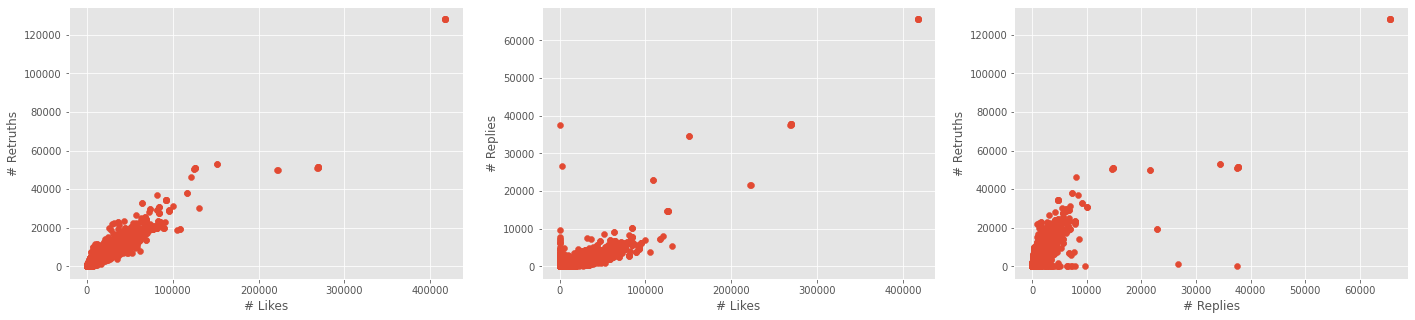

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(24, 5))

axes[0].scatter(truths['like_count'].values, truths['retruth_count'].values)
axes[0].set(xlabel='# Likes', ylabel='# Retruths')

axes[1].scatter(truths['like_count'].values, truths['reply_count'].values)
axes[1].set(xlabel='# Likes', ylabel='# Replies')


axes[2].scatter(truths['reply_count'].values, truths['retruth_count'].values)
axes[2].set(xlabel='# Replies', ylabel='# Retruths')

plt.show()

Analysing authors and content of the "outlier" posts considering like, retruth an reply count
* Selected truths based on Interquartile Range (IQR)
* Considering only the original posts (not the retruthed ones)

In [12]:
def outlier_limit(column):
    Q1 = truths[column].quantile(0.25)
    Q3 = truths[column].quantile(0.75)

    # Interquartile Range (IQR)
    IQR = Q3 - Q1
 
    # Calculate superior limit for outlier
    sup_lim = Q3 + 1.5 * IQR
    
    return sup_lim

In [13]:
print(f"Like Count Outlier limit: { outlier_limit('like_count') }")
print(f"Retruth Count Outlier limit: { outlier_limit('retruth_count') }")
print(f"Reply Count Outlier limit: { outlier_limit('reply_count') }")

Like Count Outlier limit: 12.5
Retruth Count Outlier limit: 0.0
Reply Count Outlier limit: 2.5


In [8]:
command = """
SELECT is_retruth, is_reply, author, like_count, retruth_count, reply_count, text, username, follower_count, following_count
FROM 
(SELECT *
FROM truths 
WHERE like_count >= 13 
    AND retruth_count >= 0 
    AND reply_count >= 3
    AND is_retruth = 0) AS truths
INNER JOIN users
ON truths.author = users.id
"""

cursor.execute(command)
headers = [column[0] for column in cursor.description]
res = pd.DataFrame(cursor.fetchall(), columns=headers)
res.head()

,is_retruth,is_reply,author,like_count,retruth_count,reply_count,text,username,follower_count,following_count
0,0,0,26,12300,2760,590,"On this day, let’s also never forget those who...",EricTrump,1727967.0,178.0
1,0,0,26,5660,789,346,#LIVGolf is off the charts! @TrumpBedminster,EricTrump,1727967.0,178.0
2,0,0,26,15700,3320,1110,<emoji: us><emoji: us><emoji: us>,EricTrump,1727967.0,178.0
3,0,1,26,2640,401,67,See you soon!!!,EricTrump,1727967.0,178.0
4,0,0,26,4030,512,358,Queen Elizabeth was a remarkable woman. Our de...,EricTrump,1727967.0,178.0


In [9]:
res.dropna(subset=['text'], inplace=True)

In [10]:
res.shape

(120508, 10)

**Cleaning, Processing and Visualizing text content of most engaged posts**

* Punctuations are desconsidered
* Mentions are excluded
* Hyperlinks are excluded
* English Stopwords are excluded
* Emojis are represented as following string: "<emoji: emoji_name>". This pattern is excluded from text for now.
* Biden is more cited than Trump. Other popular words are: US, truth, people, news, president, and other words related to politics.

In [35]:
# Process text   
text = res['text'].str.lower()
text = text.apply(clean_text)
text = text.apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in STOP_WORDS]))

# Count word frequency
all_words = ' '.join(text).split()
word_freq = Counter(all_words)

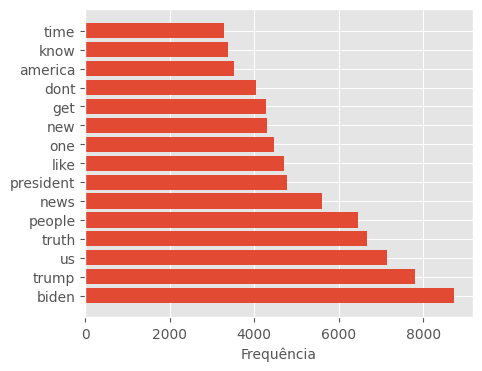

In [70]:
top_words = word_freq.most_common(15)

plt.figure(figsize=(5, 4))
plt.barh([word[0] for word in top_words], [word[1] for word in top_words])
plt.xlabel('Frequência', fontsize=10)
#plt.ylabel('Word Frequency')
#plt.xticks(rotation=45)
plt.show()

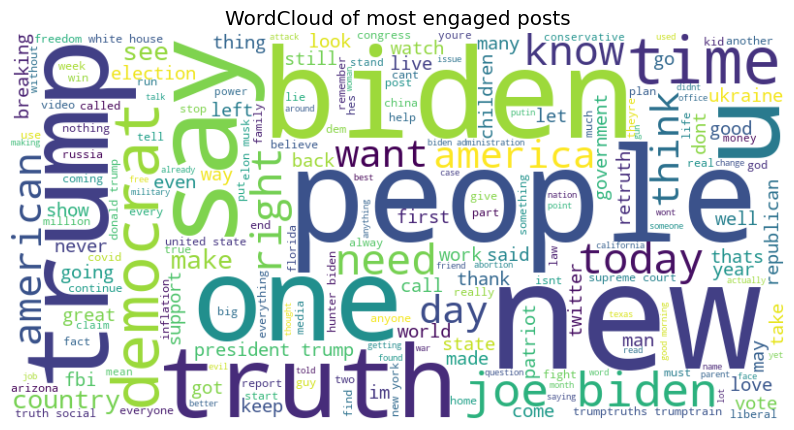

In [60]:
concat_text = ' '.join(text)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(concat_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud of most engaged posts')
plt.axis('off')  # Remover os eixos
plt.show()

**Most Engaged authors**

In [71]:
engaged_authors = res.groupby(by='username').mean()
engaged_authors.sort_values(by=['like_count', 'retruth_count', 'reply_count'], ascending=False, inplace=True)
engaged_authors[['like_count', 'retruth_count', 'reply_count']].head(10)

,like_count,retruth_count,reply_count
username,,,
realDonaldTrump,26505.831956,7268.796832,1360.110193
JonVoight,17702.222222,6824.666667,1178.555556
AmericaConservative,15979.500000,11445.000000,672.500000
therealkidrock,14520.000000,3749.500000,961.500000
Qassirriyah4279,14400.000000,5100.000000,422.000000
TuckerPost,14285.000000,8525.000000,600.000000
AnglerElitist,12400.000000,3050.000000,212.000000
DonaldJTrumpJr,11241.021739,3469.246377,835.728261
EricTrump,11206.230769,3228.492308,811.300000


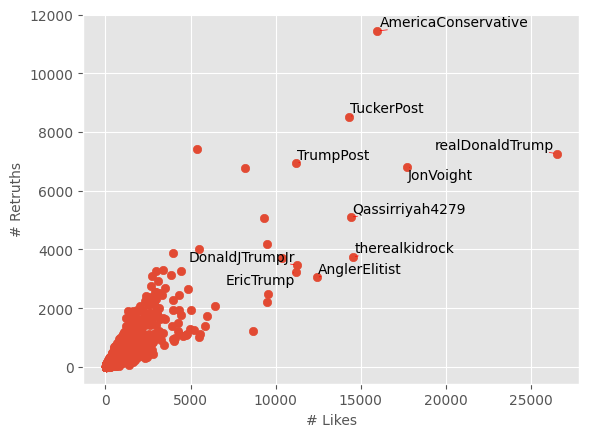

In [98]:
plt.scatter(engaged_authors['like_count'], engaged_authors['retruth_count'])

texts = []
for username in engaged_authors.head(10).index:
    texts.append(plt.text(engaged_authors.loc[username, 'like_count'], engaged_authors.loc[username, 'retruth_count'], username))
    
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red'))

plt.xlabel('# Likes', fontsize=10)
plt.ylabel('# Retruths', fontsize=10)

plt.show()

### Overall content

In [33]:
truths.dropna(subset=['text'], inplace=True)

text = truths['text'].str.lower()
text = text.apply(clean_text)
text = text.apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in STOP_WORDS]))

# Count word frequency
all_words = ' '.join(text).split()
word_freq = Counter(all_words)

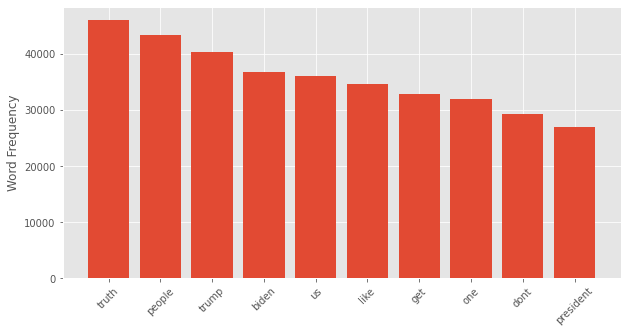

In [34]:
top_words = word_freq.most_common(10)

plt.figure(figsize=(10, 5))
plt.bar([word[0] for word in top_words], [word[1] for word in top_words])
plt.ylabel('Word Frequency')
plt.xticks(rotation=45)
plt.show()

### Emoji Usage Analysis

* Visualizing the most used emojis over all posts
* <emoji: us> is the most used One

In [20]:
import emoji

In [21]:
def extract_emojis(text):
    return re.findall(r'<emoji:\s\w+>', text)

In [22]:
truths.dropna(subset=['text'], inplace=True)

In [23]:
truths['emojis'] = truths['text'].apply(extract_emojis)
emoji_counter = Counter([emoji for emojis in truths['emojis'] for emoji in emojis])

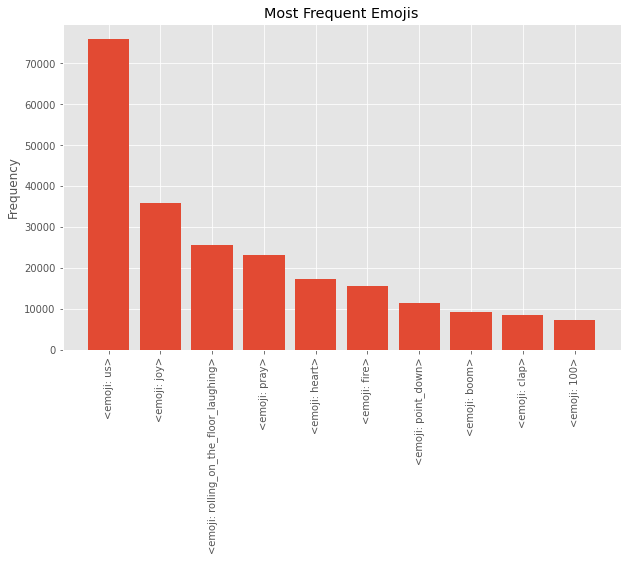

In [24]:
top_emojis = emoji_counter.most_common(10)
emojis, freq = zip(*top_emojis)

plt.figure(figsize=(10, 6))
plt.bar(emojis, freq)
plt.title('Most Frequent Emojis')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [25]:
emoji_pattern = r'<emoji:\s(.*?)>'
emoji_names = [re.search(emoji_pattern, emoji_string).group(1) for emoji_string in emojis]

for e in emoji_names:
    em = f':{e}:'
    print(emoji.emojize(em, language='alias'))

🇺🇸
😂
🤣
🙏
❤️
🔥
👇
💥
👏
💯


In [26]:
truths.drop('emojis', axis=1, inplace=True)

### Truths over time

* 81194 truths without timestamp
* The day of the highest number of posts on Truth Social (2022-03-12) coincides with the day the White House approved \$200 million in arms and equipment for Ukraine. (https://www.nytimes.com/2022/03/12/us/politics/biden-ukraine-weapons.html)

In [27]:
truths[truths['timestamp'].isnull()].shape

(81194, 13)

In [28]:
truths['day'] = truths['timestamp'].dt.date
posts_per_day = truths['day'].value_counts().sort_index()

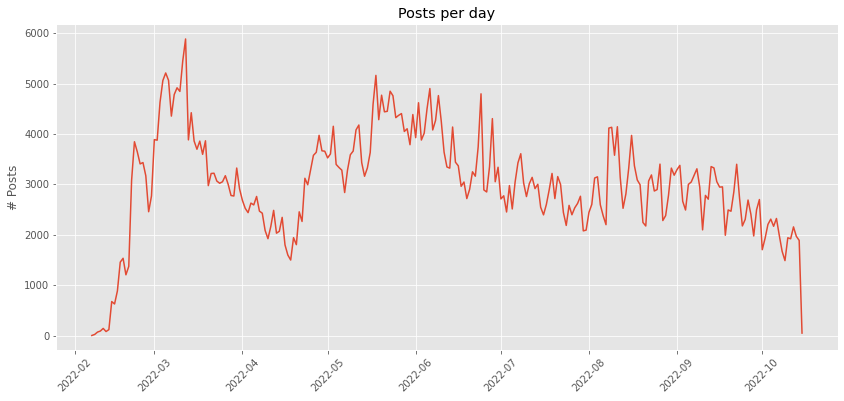

In [29]:
plt.figure(figsize=(14, 6))
posts_per_day.plot()
plt.title('Posts per day')
plt.ylabel('# Posts')
plt.xticks(rotation=45)
plt.show()

In [30]:
# Day of the highest number of posts.

posts_per_day.idxmax()

datetime.date(2022, 3, 12)

In [31]:
peak_day_truths = truths[truths['day'] == posts_per_day.idxmax()]

# Process text   
text = peak_day_truths['text'].str.lower()
text = text.apply(clean_text)
text = text.apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in STOP_WORDS]))

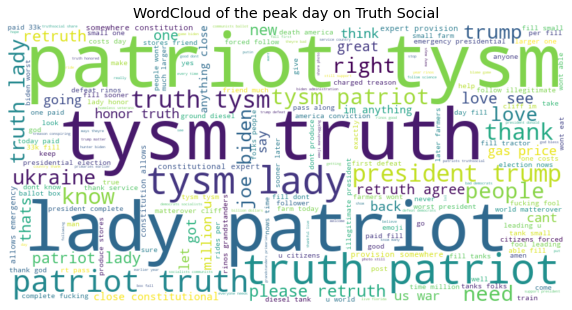

In [32]:
concat_text = ' '.join(text)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(concat_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud of the peak day on Truth Social')
plt.axis('off')  # Remover os eixos
plt.show()